# Dataset creation with Clip-seq, icSHAPE and Gene Annotation

In [1]:
import os
import pandas as pd
import numpy as np
import glob
import subprocess
import yaml, os, shutil, sys
import json
from natsort import natsorted
import tensorflow as tf
import sys
sys.path.append("../gopher/preprocessing")

In [2]:
#overall hyperparameter
#Cell line K562
input_size = 2048
base_dir = '/home/amber/multitask_RNA/data/training_dataset'
bedfile_paths_pattern = '/home/amber/multitask_RNA/data/eCLIP/K562/*/*replicate.bed'
#bedfile_paths_pattern = '/home/amber/multitask_RNA/data/eCLIP/K562/*/*peaks.bed'
bed_filepaths = [f for f in glob.glob(bedfile_paths_pattern) if f.endswith('bed') or f.endswith('gz')]
valid_chr = 'chr9'
test_chr = 'chr8'
genome = 'hg38'

## Clip-seq dataset creation through gopher binary

In [3]:
def set_genome(genome): 
    '''choose genome file paths for chr size, fa and unmappable genome segments (optional)'''
    genome_dict = {'hg38': {'size':  '/home/amber/ref/hg38/hg38.chrom.sizes',
                              'fa':  '/home/amber/ref/hg38/hg38.fa',
                              'unmap':  '/home/amber/ref/hg38/hg38_unmap.bed'}}
            
    assert genome in genome_dict.keys(), 'Unknown genome!'
    return genome_dict[genome]
    
def write_basset_samplefile(bed_filepaths, basset_samplefile):
    print('Generating merged samplefile for the entire bedfile set')
    df = pd.DataFrame(columns =['identifier', 'file'])
    # per file, get the filename
    for b, bedfile_path in enumerate(bed_filepaths):
        # make entry in basenji samplefile
        df.loc[b] = [os.path.basename(bedfile_path).split('.b')[0], bedfile_path]
    # write to csv files
    df.to_csv(basset_samplefile, index=None, header=None, sep='\t')
    

In [4]:
basset_samplefile = os.path.join(base_dir, 'basset_samplefile.csv')
write_basset_samplefile(bed_filepaths, basset_samplefile)# write pre-requisite file for the pipeline specifying bed paths

Generating merged samplefile for the entire bedfile set


In [5]:
config = {}

config['genomefile'] = set_genome(genome)

config['chroms']={'valid': valid_chr, 'test': test_chr}
config['input'] = {'size':input_size}
config['samplefile'] = {'basset': basset_samplefile}

config['output'] = {'dir': base_dir, 
                   'prefix': 'i_%i_replicate_binary' % (config['input']['size'])}
# config['output'] = {'dir': base_dir, 
#                     'prefix': 'i_%i_eclip1_binary' % (config['input']['size'])}

In [6]:
os.chdir('/home/amber/multitask_RNA/gopher/preprocessing/')
with open('config.yaml', 'w') as file:
    documents = yaml.dump(config, file, default_flow_style=False)

In [7]:
! ./bed_to_tfr.sh

Peak centering
Generating bed region combined file for all TFs
Ignoring chrY +
Ignoring chrY -
Ignoring chrM +
Ignoring chrM -
Ignoring chr14_GL000194v1_random -
Ignoring chrUn_GL000219v1 -
Ignoring chr1_KI270711v1_random -
Ignoring chrUn_GL000218v1 -
Ignoring chr22_KI270733v1_random +
Ignoring chr14_GL000009v2_random -
Ignoring chrUn_GL000220v1 +
train test validation split
LOADING DATA
Ignoring header line
LOADING DATA
LOADING DATA
rm: cannot remove '/home/amber/multitask_RNA/data/training_dataset/i_2048_replicate_sigmoid.bed': No such file or directory
rm: cannot remove '/home/amber/multitask_RNA/data/training_dataset/i_2048_replicate_sigmoid_act.bed': No such file or directory


In [8]:
! sort -V -k1,1 -k2,2 /home/amber/multitask_RNA/data/training_dataset/i_2048_replicate_binary/i_2048_replicate_binary.bed > /home/amber/multitask_RNA/data/training_dataset/i_2048_replicate_binary/i_2048_replicate_binary.sorted.bed
#! sort -V -k1,1 -k2,2 /home/amber/multitask_RNA/data/training_dataset/i_2048_eclip1_binary/i_2048_eclip1_binary.bed > /home/amber/multitask_RNA/data/training_dataset/i_2048_eclip1_binary/i_2048_eclip1_binary.sorted.bed

## Gene annotation gtf file

In [9]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [10]:
colnames=['Chrom', 'Database', 'Annotation', 'Start','End','Score','Strand','Phase','Notes'] 
annotation_df = pd.read_csv('/home/amber/multitask_RNA/data/gencode.v40.annotation.gtf',
                            sep='\t',skiprows=5,names=colnames,header=None)
annotation_df = annotation_df.drop('Phase', 1)
annotation_df = annotation_df.drop('Score', 1)
annotation_df['GeneID'] = annotation_df['Notes'].apply(lambda x: x.split('"')[1])

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [14]:
exon_df = annotation_df[annotation_df['Annotation']=='exon']
exon_df['TranscriptID'] = exon_df['Notes'].apply(lambda x : x.split('"')[3])

/tmp/ipykernel_3315861/2720617361.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exon_df['TranscriptID'] = exon_df['Notes'].apply(lambda x : x.split('"')[3])


In [15]:
trans_id_list = []
gene_list = annotation_df['GeneID'].unique()
all_transcript_df = annotation_df[annotation_df['Annotation'] == 'transcript']
for gene in tqdm(gene_list,total=len(gene_list)):
    transcript_df = all_transcript_df[all_transcript_df['GeneID']==gene]
    trans_length = transcript_df['End'] - transcript_df['Start']
    max_trans_index = np.argmax(trans_length)
    max_trans = transcript_df.iloc[max_trans_index]
    max_id = max_trans['Notes'].split('"')[3]
    trans_id_list.append(max_id)

  0%|          | 0/61544 [00:00<?, ?it/s]

In [16]:
selected_exon = exon_df[exon_df['TranscriptID'].isin(trans_id_list)]
len(selected_exon)

296577

In [17]:
selected_exon.to_csv('/home/amber/multitask_RNA/data/training_dataset/exon_label.bed',sep='\t',
              index=False,columns=['Chrom','Start','End','Annotation','GeneID'],header=False)

In [19]:
! sort -V -k1,1 -k2,2 /home/amber/multitask_RNA/data/training_dataset/exon_label.bed > /home/amber/multitask_RNA/data/training_dataset/exon_label.sorted.bed

## Create annotation vector according to Clip-seq peak centered region

In [10]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import csv

In [11]:
sorted_bed = '/home/amber/multitask_RNA/data/training_dataset/i_2048_replicate_binary/i_2048_replicate_binary.sorted.bed'
#sorted_bed = '/home/amber/multitask_RNA/data/training_dataset/i_2048_eclip1_binary/i_2048_eclip1_binary.sorted.bed'
exon_bed= '/home/amber/multitask_RNA/data/training_dataset/exon_label.sorted.bed'

In [12]:
def get_cord(bed_row):
    a = bed_row.rstrip().split('\t')
    if a[0][3:] == 'M':
        chrom = 23
    elif a[0][3:] == 'X':
        chrom = 24
    elif a[0][3:] == 'Y':
        chrom = 25
    else:
        chrom = int(a[0][3:])
    start = int(a[1])
    end = int(a[2])
    return chrom,start,end


train_annotation = []
valid_annotation = []
test_annotation = []
exon = open(exon_bed, "r")
e_chrom,e_start,e_end = get_cord(exon.readline())
current_chr = e_chrom

for line in open(sorted_bed):
    #initiate region and target
    chrom,start,end = get_cord(line)
    tmp_vector = np.array([0] * (end-start))
    
    #Make sure both pointer are at same chromosome
    while e_chrom > chrom:
        if chrom == int(valid_chr[3:]):
            valid_annotation.append(tmp_vector)
        elif chrom == int(test_chr[3:]):
            test_annotation.append(tmp_vector)
        else:
            train_annotation.append(tmp_vector)
        break
    while chrom > e_chrom:
        e_chrom,e_start,e_end = get_cord(exon.readline())

    #exon occur before selected region, look for next exon with overlap
    while e_end < start:
        e_chrom,e_start,e_end = get_cord(exon.readline()) 
        if e_chrom > chrom:
            break
    #At least partial overlap with selected region
    while end >= e_start:
        if e_chrom > chrom:
            break
        #exon completely included in selected region
        if end >= e_end:
            if e_start <= start:
                tmp_vector[0:e_end-start] = 1
            else:
                tmp_vector[e_start-start:e_end-start] = 1
            #look for next exon
            e_chrom,e_start,e_end = get_cord(exon.readline())
            
        #exon (at least partly) extend over selected region
        #may have more overlap with next selected region
        else:
            tmp_vector[e_start-start:end-e_start] = 1
            #does not update pointer to next exon
            break
    #create target vector for each region in selected bed file
    if chrom == int(valid_chr[3:]):
        valid_annotation.append(tmp_vector)
    elif chrom == int(test_chr[3:]):
        test_annotation.append(tmp_vector)
    else:
        train_annotation.append(tmp_vector)

In [13]:
len(train_annotation)+len(test_annotation)+ len(valid_annotation)

70439

## icSHAPE-seq crop BigWig according to bed regions

In [19]:
import pyBigWig
plus_bw = '/home/amber/multitask_RNA/data/icSHAPE/K562-plus.bw'
minus_bw = '/home/amber/multitask_RNA/data/icSHAPE/K562-minus.bw'

In [20]:
plus_file = pyBigWig.open(plus_bw)
minus_file = pyBigWig.open(minus_bw)
train_shape = []
valid_shape = []
test_shape = []
for line in open(sorted_bed):
    
    a = line.rstrip().split('\t')
    chrom = a[0]
    start = int(a[1])
    end = int(a[2])
    
    plus_target = plus_file.values(chrom,start,end,numpy=True)
    minus_target = minus_file.values(chrom,start,end,numpy=True)
    
    shape_target = np.vstack((plus_target,minus_target)).T
    #shape_target[np.isnan(shape_target)]=0.5
    #shape_target = 2*(shape_target-0.5)
    
    if chrom == valid_chr:
        valid_shape.append(shape_target)
    elif chrom == test_chr:
        test_shape.append(shape_target)
    else:
        train_shape.append(shape_target)

In [25]:
np.sum(np.isnan(train_shape))

256553161

In [30]:
len(train_shape) * 2048*2

265900032

In [31]:
256553161 / 265900032

0.9648481764755862

In [20]:
len(train_shape)+len(test_shape)+ len(valid_shape)

70439

In [21]:
quant_test = np.concatenate((test_shape,np.expand_dims(test_annotation,axis=-1)),axis=-1)
quant_valid = np.concatenate((valid_shape,np.expand_dims(valid_annotation,axis=-1)),axis=-1)
quant_train = np.concatenate((train_shape,np.expand_dims(train_annotation,axis=-1)),axis=-1)

In [22]:
print(quant_test.shape)
print(quant_valid.shape)
print(quant_train.shape)

(2799, 2048, 3)
(2723, 2048, 3)
(64917, 2048, 3)


In [23]:
import h5py
f = h5py.File('/home/amber/multitask_RNA/data/training_dataset/i_2048_replicate_binary/i_2048_replicate_binary.h5','a')
#f = h5py.File('/home/amber/multitask_RNA/data/training_dataset/i_2048_eclip1_binary/i_2048_eclip1_binary.h5','a')
f.create_dataset('quant_train', data=quant_train)
f.create_dataset('quant_valid', data=quant_valid)
f.create_dataset('quant_test', data=quant_test)
f.close()

## MT_Splice data

In [1]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv("./data/MT_Splice/gtex_train_psi.csv",index_col = 0)

In [8]:
cell_line_list = ['Retina - Eye', 'RPE/Choroid/Sclera - Eye', 'Subcutaneous - Adipose',
       'Visceral (Omentum) - Adipose', 'Adrenal Gland', 'Aorta - Artery',
       'Coronary - Artery', 'Tibial - Artery', 'Bladder', 'Amygdala - Brain',
       'Anterior cingulate - Brain', 'Caudate nucleus - Brain',
       'Cerebellar Hemisphere - Brain', 'Cerebellum - Brain', 'Cortex - Brain',
       'Frontal Cortex - Brain', 'Hippocampus - Brain', 'Hypothalamus - Brain',
       'Nucleus accumbens - Brain', 'Putamen - Brain',
       'Spinal cord (C1) - Brain', 'Substantia nigra - Brain',
       'Mammary Tissue - Breast', 'EBV-xform lymphocytes - Cells',
       'Leukemia (CML) - Cells', 'Xform. fibroblasts - Cells',
       'Ectocervix - Cervix', 'Endocervix - Cervix', 'Sigmoid - Colon',
       'Transverse - Colon', 'Gastroesoph. Junc. - Esophagus',
       'Mucosa - Esophagus', 'Muscularis - Esophagus', 'Fallopian Tube',
       'Atrial Appendage - Heart', 'Left Ventricle - Heart', 'Cortex - Kidney',
       'Liver', 'Lung', 'Minor Salivary Gland', 'Skeletal - Muscle',
       'Tibial - Nerve', 'Ovary', 'Pancreas', 'Pituitary', 'Prostate',
       'Not Sun Exposed - Skin', 'Sun Exposed (Lower leg) - Skin',
       'Ileum - Small Intestine', 'Spleen', 'Stomach', 'Testis', 'Thyroid',
       'Uterus', 'Vagina', 'Whole Blood']

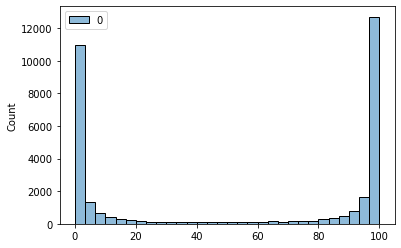

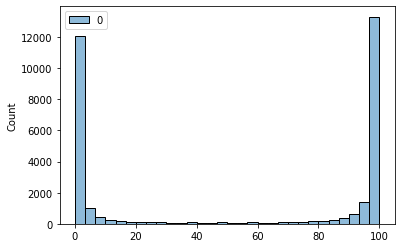

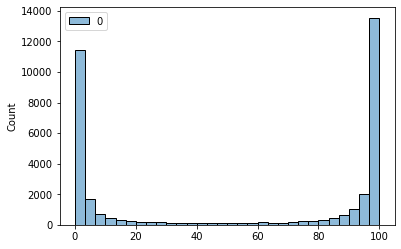

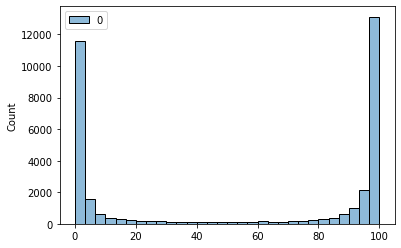

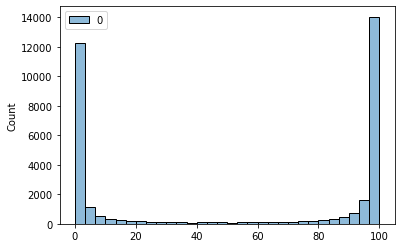

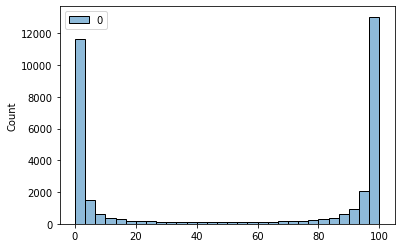

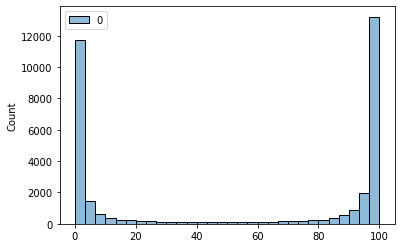

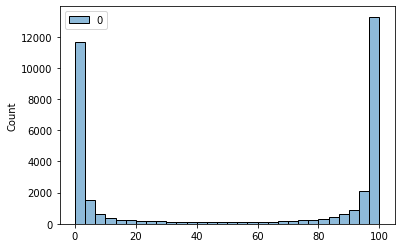

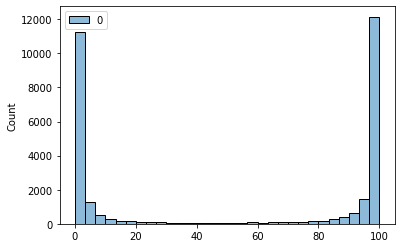

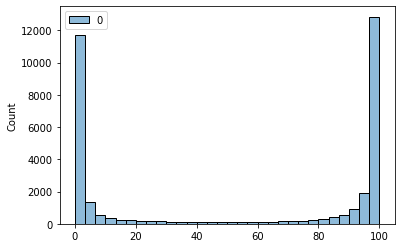

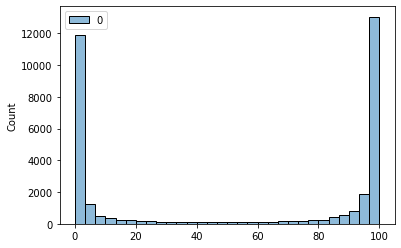

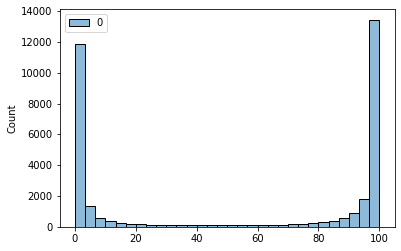

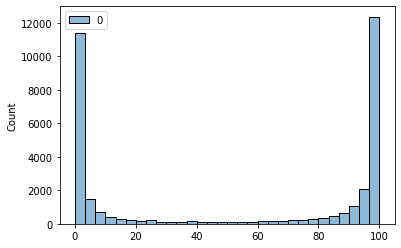

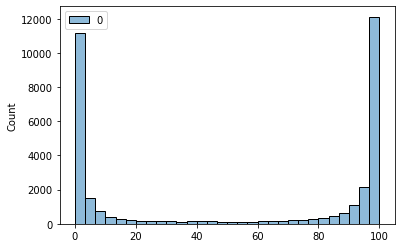

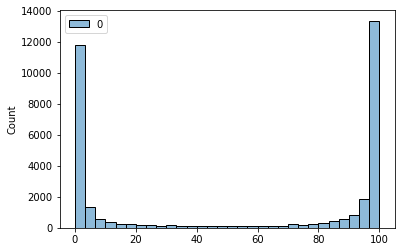

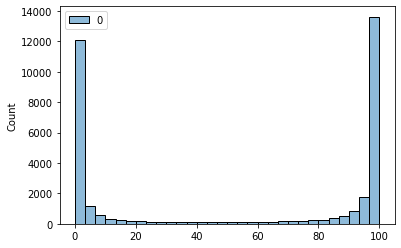

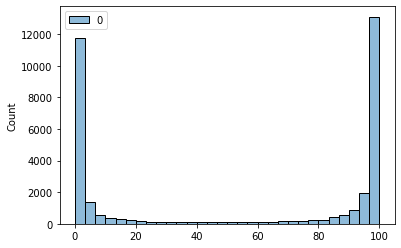

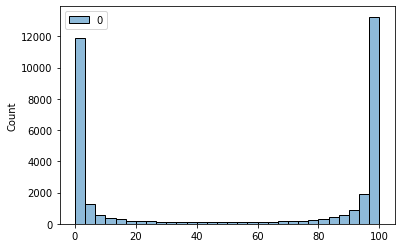

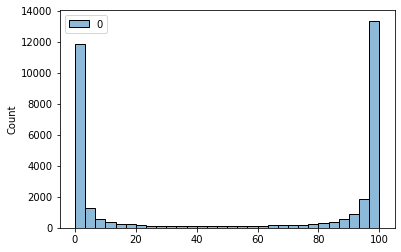

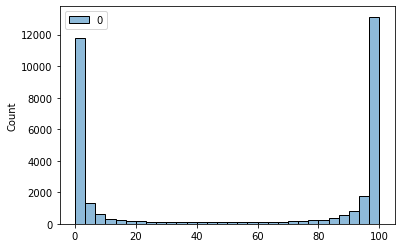

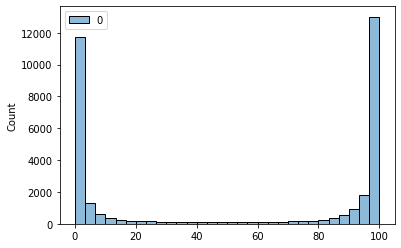

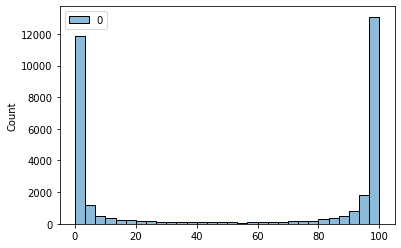

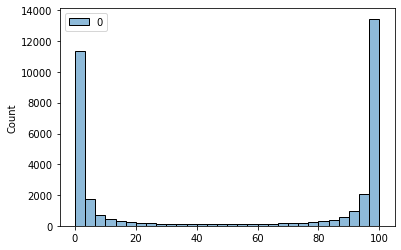

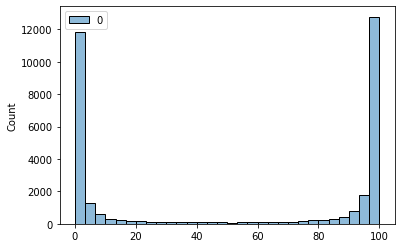

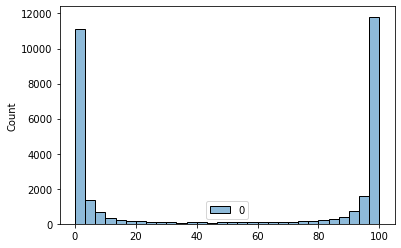

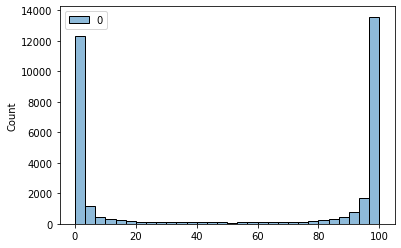

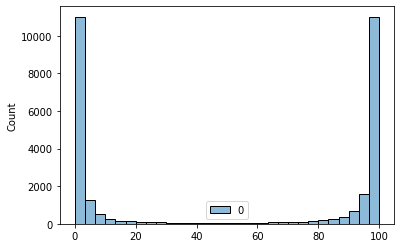

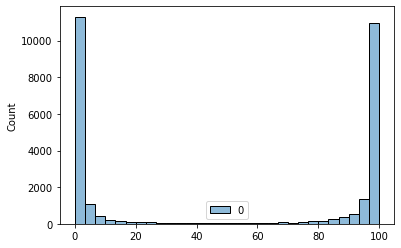

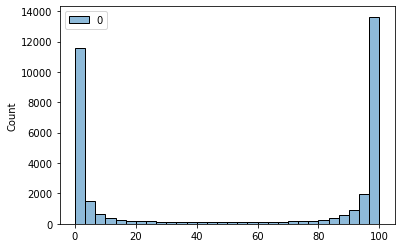

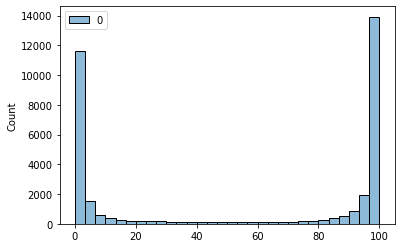

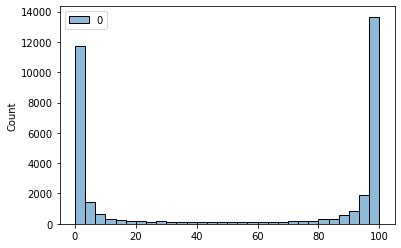

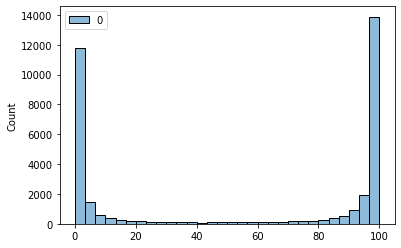

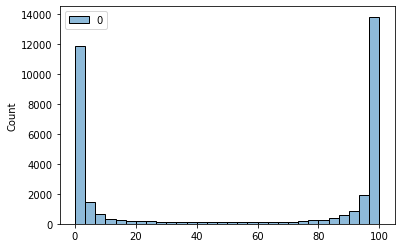

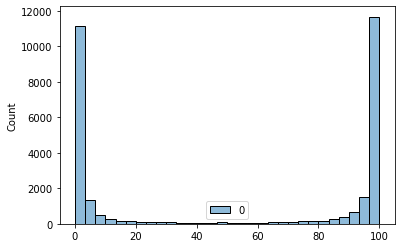

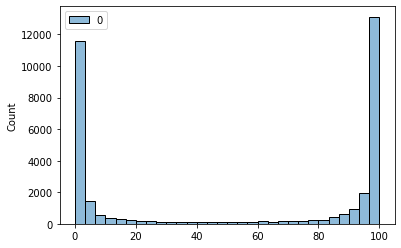

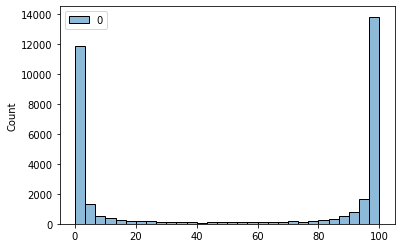

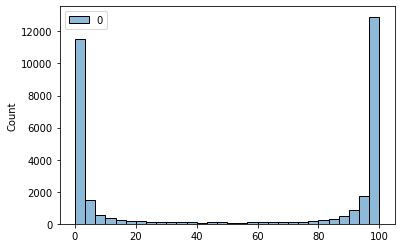

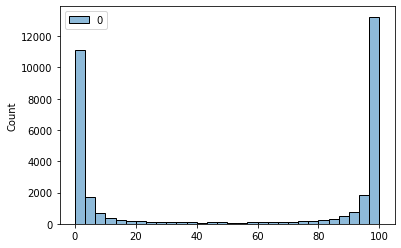

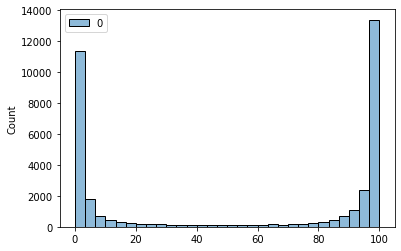

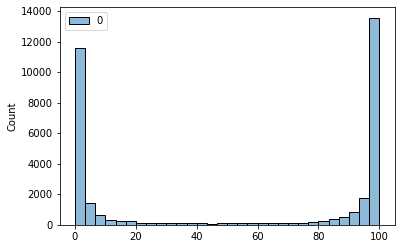

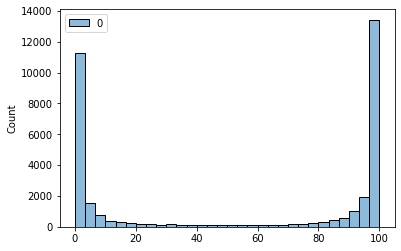

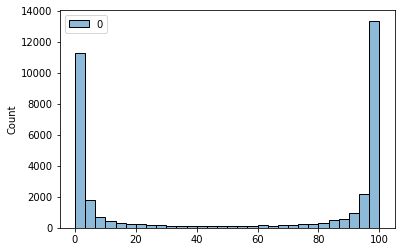

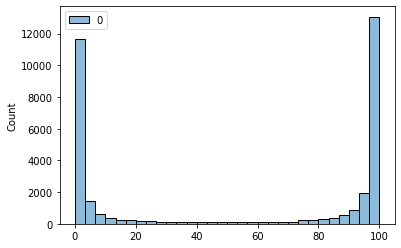

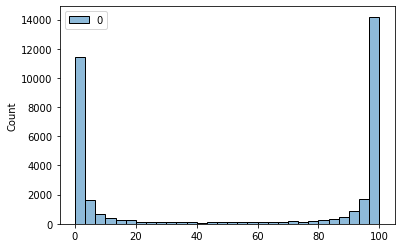

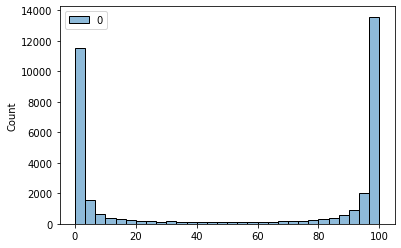

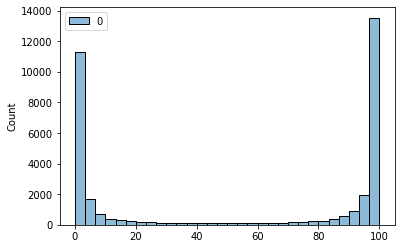

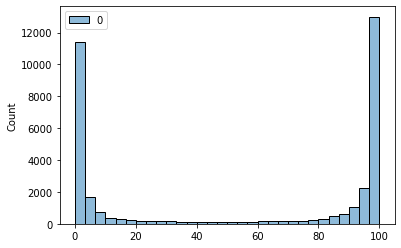

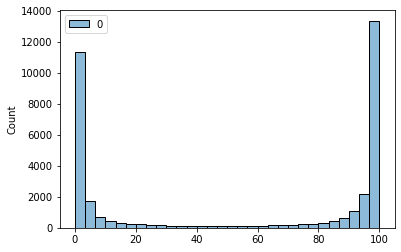

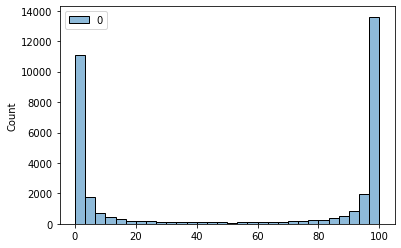

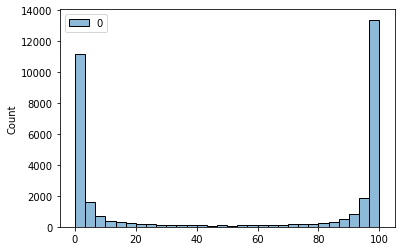

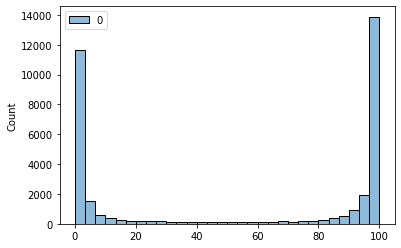

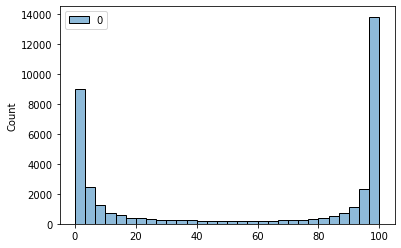

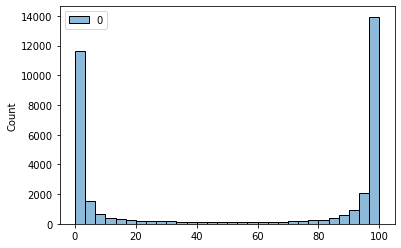

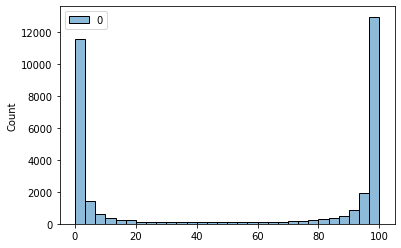

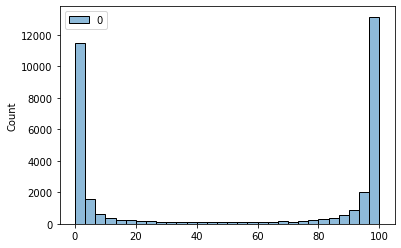

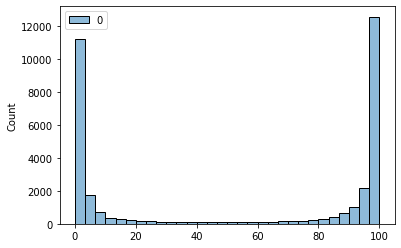

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
for col in cell_line_list:
    data_col = df[col].values
    idx = np.argwhere(data_col != -1)
    dist = data_col[idx]
    sns.histplot(dist,bins=30)
    plt.show()
    

In [12]:
data_col

array([-1.        , 15.66341063, -1.        , ..., 99.74600946,
       99.49440791, 99.92829268])